In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dem_stitcher.stitcher import download_dem
import rasterio
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from pathlib import Path
from dem_stitcher.rio_tools import crop_profile_from_coord_bounds
from dem_stitcher.stitcher import merge_tiles
from rasterio import default_gtiff_profile
import numpy as np

In [3]:
site = 'odessa' # 'bay_area' or 'aleutian' or 'odessa'
dem_0 = 'glo_30' # 'ned1' #'tdx_30'
dem_1 = 'nasadem' # 'ned1'
save_raw_tiles = True

In [4]:
if site == 'bay_area':
    bounds = [-121.5, 34.95, -120.2, 36.25]
elif site == 'aleutian':
    bounds = [-170, 51, -160, 56]
elif site == 'odessa':
    bounds = [-103, 31, -101.5, 33]    
else:
    raise ValueError('Site not valid')

# dem_0

In [5]:
%%time

out_path_0 = download_dem(bounds, 
                          dem_0, 
                          f'sample_{dem_0}_{site}',
                          save_raw_tiles=save_raw_tiles,
                          # More than 5 workers can cause timeout errors.
                          max_workers=5)
out_path_0

/Users/cmarshak/bekaert-team/dem-stitcher/dem_stitcher/stitcher.py:124: UserWarning: sample_glo_30_odessa exists; data will be overwritten
  warnings.warn(f'{dest_dir} exists; data will be overwritten')


CPU times: user 26.7 s, sys: 3.91 s, total: 30.6 s
Wall time: 58.3 s


PosixPath('sample_glo_30_odessa/glo_30.dem.wgs84')

In [6]:
with rasterio.open(out_path_0) as ds:
    print(ds.bounds)
    X_0 = ds.read(1)
    p_0 = ds.profile

BoundingBox(left=-103.00041666666667, bottom=30.99986111111111, right=-101.49986111111112, top=33.000416666666666)


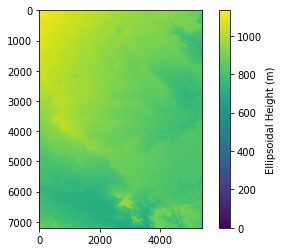

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(X_0, vmin=0)
fig.colorbar(im, label='Ellipsoidal Height (m)')

In [8]:
p_0

{'driver': 'ISCE', 'dtype': 'float32', 'nodata': nan, 'width': 5402, 'height': 7202, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -103.00041666666667,
       0.0, -0.0002777777777777778, 33.000416666666666), 'tiled': False}

# dem_1

In [9]:
%%time

out_path_1 = download_dem(bounds, 
                          dem_1, 
                          f'sample_{dem_1}_{site}',
                          save_raw_tiles=save_raw_tiles,
                          max_workers=5)
out_path_1

/Users/cmarshak/bekaert-team/dem-stitcher/dem_stitcher/stitcher.py:124: UserWarning: sample_nasadem_odessa exists; data will be overwritten
  warnings.warn(f'{dest_dir} exists; data will be overwritten')


CPU times: user 6.85 s, sys: 3.75 s, total: 10.6 s
Wall time: 29.8 s


PosixPath('sample_nasadem_odessa/nasadem.dem.wgs84')

In [10]:
with rasterio.open(out_path_1) as ds:
    X_1 = ds.read(1)
    p_1 = ds.profile
  

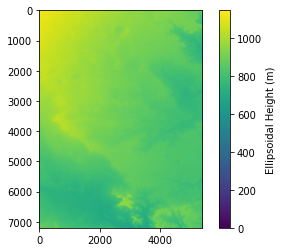

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(X_1, vmin=0)
fig.colorbar(im, label='Ellipsoidal Height (m)')

In [12]:
p_1

{'driver': 'ISCE', 'dtype': 'float32', 'nodata': nan, 'width': 5402, 'height': 7202, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -103.00041666666667,
       0.0, -0.0002777777777777778, 33.000416666666666), 'tiled': False}

# Comparison

In [14]:
X_1_r, _ = reproject_arr_to_match_profile(X_1, p_1, p_0)
X_1_r = X_1_r[0, ...]

Text(0.5, 0, 'nasadem - glo_30 (m)')

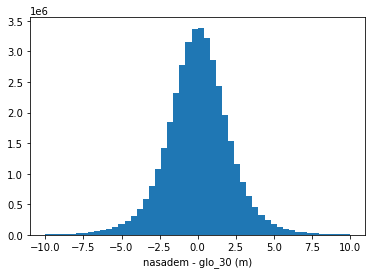

In [15]:
diff = (X_1_r - X_0)
diff_r = diff[~np.isnan(diff)]
plt.hist(diff_r, bins=50, range=(-10, 10))
plt.xlabel(f'{dem_1} - {dem_0} (m)')

In [16]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'diff': diff_r})
df['diff_cm'] = np.round(df['diff'] * 100, 3)
df.drop(columns=['diff'], inplace=True)
df.describe()

,diff_cm
count,3.889260e+07
mean,3.940392e+00
std,2.209649e+02
min,-1.031594e+04
25%,-1.205930e+02
50%,4.498000e+00
75%,1.299560e+02
max,8.761737e+03


In [22]:
T = 50
p = np.sum(np.abs(df.diff_cm) < 50) / df.shape[0]
print(f'percent less than {T} cm: {p*100:1.2f}%')
df[(np.abs(df.diff_cm) < T)].describe()

percent less than 50 cm: 21.60%


,diff_cm
count,8.399401e+06
mean,1.100213e-01
std,2.867934e+01
min,-4.999400e+01
25%,-2.457300e+01
50%,1.400000e-01
75%,2.482300e+01
max,4.999400e+01


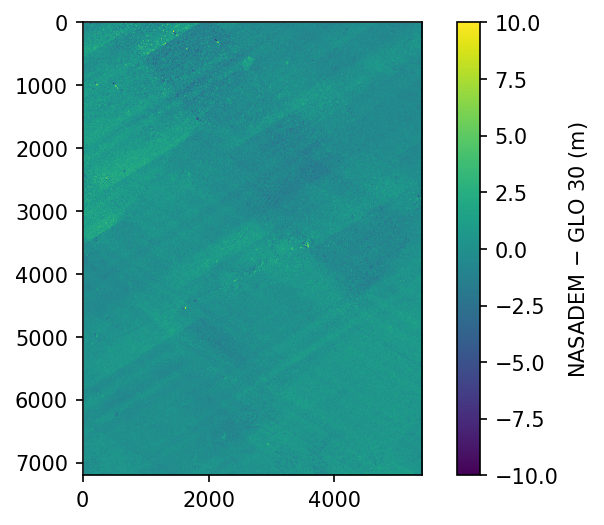

In [18]:
fig, ax = plt.subplots(dpi=150)
im = ax.imshow(diff, vmin=-10, vmax=10)
fig.colorbar(im, label=f'{dem_1.upper().replace("_", " ")} $-$ {dem_0.upper().replace("_", " ")} (m)')

In [19]:
pp = p_0.copy()
pp['driver'] = 'GTiff'
with rasterio.open(f'diff_{dem_1}_m_{dem_0}.tif', 'w', **pp) as ds:
    ds.write(diff, 1)